# Post processing the AGWB

This notebook contains some of the functions I used to create figures from the calculated GWB.

## Imports and settings

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as cst
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import seaborn as sns

# matplotlib globals
plt.rc('font',   size=12)          # controls default text sizes
plt.rc('axes',   titlesize=14)     # fontsize of the axes title
plt.rc('axes',   labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=14)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=14)     # fontsize of the tick labels
plt.rc('legend', fontsize=14)      # legend fontsize
plt.rc('figure', titlesize=14)     # fontsize of the figure title

## Auxiliary

In [17]:
########## PARAMETERS AND DATA ##########

# LVK O3, alpha = 2/3 at 25 Hz
Omega_upp = 3.4*10**(-9)
Omega_BBH = 4.7*10**(-10)
Omega_BNS = 2.*10**(-10)

Omega_BBH_up = 6.3*10**(-10)
Omega_BNS_up = 5.2*10**(-10)
Omega_BBH_low = 3.3*10**(-10)
Omega_BNS_low = 0.6*10**(-10)

# Farmer and Phinney, at 1 mHz
Omega_BWD = 3.57*10**(-12)
Omega_BWD_up = 6.*10**(-12)
Omega_BWD_low = 1.*10**(-12)

# LISA parabola approximation
def calc_parabola_vertex(x1: float, y1: float, x2: ﬂoat, y2: float, x3: float, y3: float) -> tuple:
    '''!
    @brief Calculate the coefficients of a parabola given 3 points
    @param x1: x coordinate of the first point
    @param y1: y coordinate of the first point
    @param x2: x coordinate of the second point
    @param y2: y coordinate of the second point
    @param x3: x coordinate of the third point
    @param y3: y coordinate of the third point
    @return A: coefficient of the x^2 term
    @return B: coefficient of the x term
    @return C: constant term
    '''
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom

    return A,B,C

a, b, c = calc_parabola_vertex(-3, -12, -2.5, -12.5, -2, -12)

In [18]:
def get_z_list_bins_from_time(max_z: float, N_int: int) -> tuple:
    '''!
    @brief Get a list of redshifts and the corresponding bins from a given lookback time
    @param max_z: maximum redshift
    @param N_int: number of integration bins
    @return z_list: list of redshifts
    @return z_bins: list of redshift bins
    '''
    T0 = cosmo.lookback_time(max_z)
    T_range = np.linspace(0, T0.value, 2*N_int+1)

    T_list = np.array([T_range[2*i+1] for i in range(N_int)])
    T_bins = np.array([T_range[2*i] for i in range(N_int+1)])

    z_list = []
    z_bins = []
    for time in T_list:
        z_list.append(z_at_value(cosmo.lookback_time, time * u.Gyr).value)
    for time in T_bins[1:]:
        z_bins.append(z_at_value(cosmo.lookback_time, time * u.Gyr).value)

    return z_list, z_bins

def Omega(Omega_ref: float, f_ref: float, freq: np.array) -> np.array:
    '''!
    @brief Create quick f^2/3 spectrum.
    @param Omega_ref: reference value of Omega
    @param f_ref: reference frequency
    @param freq: frequency array
    @return Omega: Omega array
    '''
    return Omega_ref*10**((2/3) * (np.log10(freq) - np.log10(f_ref)))

def parabola(freq: np.array, a: float, b: float, c: float) -> np.array:
    '''!
    @brief Parabola function
    @param freq: frequency array
    @param a: coefficient of the x^2 term
    @param b: coefficient of the x term
    @param c: constant term
    @return y: y array
    '''
    return a*freq**2 + b*freq+c

def make_Omega_plot(f: np.array, Omega_sim: np.array, save: bool = False, save_name: str = "void", SIM_ERROR: bool = False) -> None:
    '''!
    @brief Make Omega plot
    @param f: frequency array
    @param Omega_sim: Omega array
    @param save: save the plot
    @param save_name: name of the saved plot
    @param SIM_ERROR: include the error of the simulation
    '''
    freq = np.logspace(-5, 0, 1000, base = 10)

    fig, ax = plt.subplots(1, 1)

    ax.plot(np.log10(freq), Omega(Omega_upp, 25, freq), linestyle = "dashed", label = "LVK Upp", color = "grey", linewidth = 3)
    ax.plot(np.log10(freq), Omega(Omega_BBH, 25, freq), label = "LVK BBH", color = "tab:green", linewidth = 3)
    ax.plot(np.log10(freq), Omega(Omega_BNS, 25, freq), label = "LVK BNS", color = "tab:blue", linewidth = 3)
    ax.plot(np.log10(f), Omega_sim, color = "salmon", linewidth = 6, alpha=0.8, label = "Sim BWD")
    ax.plot(np.log10(freq), 10**parabola(np.log10(freq), a, b, c), color = "black", label = "LISA", linewidth = 2)
    ax.fill_between(np.log10(freq), Omega(Omega_BBH_low, 25, freq), Omega(Omega_BBH_up, 25, freq), color = "tab:green", alpha = 0.2)
    ax.fill_between(np.log10(freq), Omega(Omega_BNS_low, 25, freq), Omega(Omega_BNS_up, 25, freq), color = "tab:blue", alpha = 0.2)
    if SIM_ERROR:
        ax.fill_between(np.log10(f), Omega_sim*10**(-0.2), Omega_sim*10**(0.2), color = "green", alpha = 0.2)
    
    freq = np.logspace(-3.5, -1.2, 1000, base = 10)
    fhat = 7.2e-3
    fit = 2.4e-11 * (freq/fhat)**(0.73) * (1 + (freq/fhat)**(4.1)) ** (-0.23) * np.exp(-1.2e4 * freq**3)
    ax.plot(np.log10(freq), fit, label = "fit", color = "red")
    
    ax.grid(color = "gainsboro", alpha = 0.7)
    ax.set_xlabel(r"$\log_{10}(f$ / Hz$)$")
    ax.set_ylabel(r"$\Omega_{GW}$")

    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim(10**(-13), 10**(-9))
    ax.set_xlim(-4.3, -1)
    if save:
        plt.tight_layout()
        fig.savefig("../output/Figures/" + save_name + ".png")

    plt.show()    

def make_Omega_compare_plot(data1: pd.DataFrame, data2:pd.DataFrame) -> None:
    '''!
    @brief Make plot to compare Omega between two data sets
    @param data1: first dataset
    @param data2: second dataset
    '''
    freq = np.logspace(-5, 0, 1000, base = 10)

    fig, ax = plt.subplots(1, 1)

    ax.plot(np.log10(freq), Omega(Omega_upp, 25, freq), linestyle = "dashed", label = "LVK Upp", color = "grey", linewidth = 3)
    ax.plot(np.log10(freq), Omega(Omega_BBH, 25, freq), label = "LVK BBH", color = "tab:green", linewidth = 3)
    ax.plot(np.log10(freq), Omega(Omega_BNS, 25, freq), label = "LVK BNS", color = "tab:blue", linewidth = 3)
    ax.plot(np.log10(data1.f), data1.Om, color = "red", linewidth = 3, label = "data 1")
    ax.plot(np.log10(data2.f), data2.Om, color = "orange", linewidth = 3, label = "data 2")
    ax.plot(np.log10(freq), 10**parabola(np.log10(freq), a, b, c), color = "black", label = "LISA", linewidth = 2)
    ax.fill_between(np.log10(freq), Omega(Omega_BBH_low, 25, freq), Omega(Omega_BBH_up, 25, freq), color = "tab:green", alpha = 0.2)
    ax.fill_between(np.log10(freq), Omega(Omega_BNS_low, 25, freq), Omega(Omega_BNS_up, 25, freq), color = "tab:blue", alpha = 0.2)
    
    ax.grid(color = "gainsboro", alpha = 0.7)
    ax.set_xlabel(r"$\log_{10}(f$ / Hz$)$")
    ax.set_ylabel(r"$\Omega_{GW}$")

    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim(10**(-13), 10**(-9))
    ax.set_xlim(-4.5, -1.)

    plt.show() 

## Visualizing the population

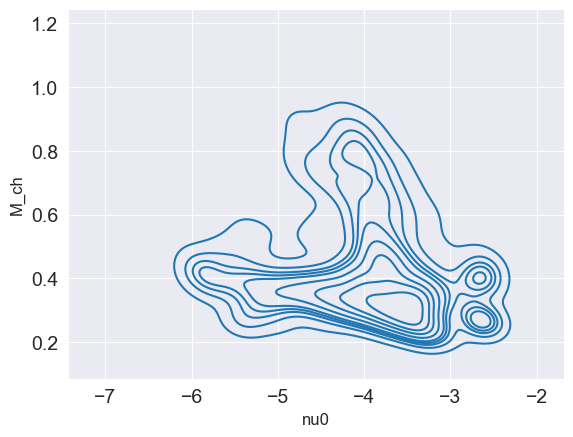

In [20]:
initial = pd.read_csv("../data/AlphaAlpha/Alpha4/z02/Initials_z02_Seppe.txt.gz", sep = ",", header=0)

sns.kdeplot(x = np.log10(2*initial.nu0), y= initial.M_ch)

plt.show()


## Omega plots

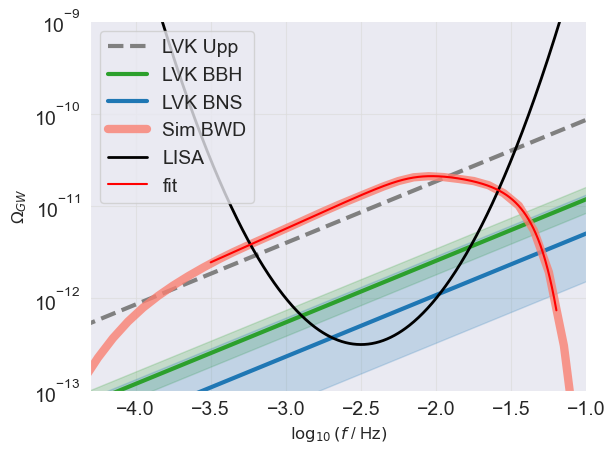

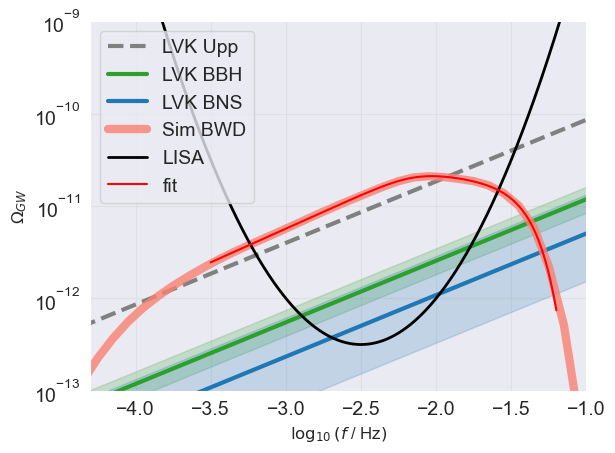

In [22]:
data_1 = pd.read_csv("../output/GWBs/SFH1_50_20_wmerge_example_z.txt")
data_2 = pd.read_csv("../output/GWBs/SFH1_50_20_wmerge_example_T.txt.gz")

make_Omega_plot(data_1.f, data_1.Om, save=False, save_name="SFH1_50_20_example_z")
make_Omega_plot(data_2.f, data_2.Om, save=False, save_name="SFH1_50_20_example_T")

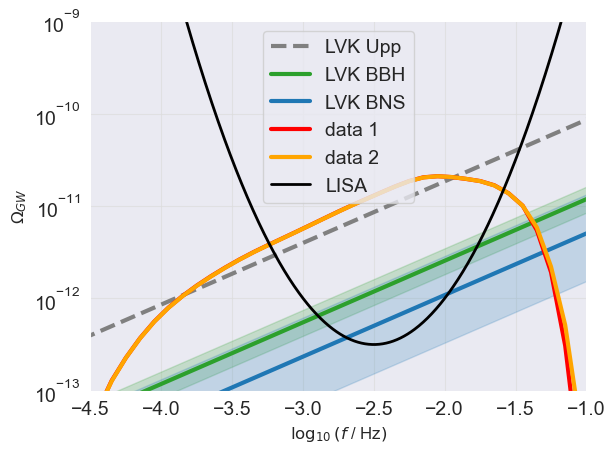

Max difference: 6.84704751216758e-14


In [23]:
make_Omega_compare_plot(data_1, data_2)

print(f"Max difference: {np.max(data_1.Om - data_2.Om)}")

## Stacked bar chart: cosmic time bins

This section is to create Figure 4 in [Staelens, Nelemans 2024](https://www.aanda.org/articles/aa/full_html/2024/03/aa48429-23/aa48429-23.html).

### Function

In [24]:
def stacked_bar_chart(data1: pd.DataFrame, data2: pd.DataFrame, data3: pd.DataFrame, SFH:int, N_freq: int, N_int: int, tag: str, SAVE: bool = False, z_threshold: float = 0.46) -> None:
    """!
    @brief Create a stacked bar chart of the contribution of the different redshift bins to the different frequency bins.
    @param data1: The first data set. (bulk)
    @param data2: The second data set. (birth)
    @param data3: The third data set. (merger)
    @param N_freq: The number of frequency bins.
    @param N_int: The number of integration bins.
    @param SAVE: Whether to save the figure or not.
    @param z_threshold: The redshift threshold to draw a line at.
    """
    assert N_freq == 25 or N_freq == 50, "Currently only implement for N_freq 25 or 50."

    # create the frequency bins
    f_range = np.logspace(-5, 0, 2*N_freq+1, base = 10)
    f_plot = np.log10(np.array([f_range[2*i+1] for i in range(N_freq)]))

    # redshift values
    z_list = data1.z
    _, z_bins = get_z_list_bins_from_time(8, N_int)
    new_data = pd.DataFrame({"z":z_list})

    # colors for the different integration bins
    colors = plt.cm.get_cmap('viridis', N_int//2)
    
    # Calculate the percentage contribution of the redshift bins
    for i in range(N_freq):
        new_data[f"prop_f_{i}"] = 99* (data1[f"freq_{i}"]+data2[f"freq_{i}"]+data3[f"freq_{i}"]) / (data1[f"freq_{i}"].sum()+data2[f"freq_{i}"].sum()+data3[f"freq_{i}"].sum())
    
    # don't need the z column anymore
    new_data.drop("z", inplace=True, axis = 1)

    # set up figure
    fig, ax = plt.subplots(1, 1, figsize = (9,6))

    if N_freq == 25:

        width = (f_plot[2]-f_plot[1])

        ax.bar(f_plot, new_data.iloc[0] + new_data.iloc[1], 
            color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
        sum = new_data.iloc[0] + new_data.iloc[1]

    elif N_freq == 50:

        width = 2*(f_plot[2]-f_plot[1])

        ax.bar(f_plot[::2], new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2], 
            color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
        sum = new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2]

    draw_line = False
    prev_z_bin = z_bins[1]

    for i, z in enumerate(z_bins[3::2]):

        if N_freq == 25:
            props = new_data.iloc[2*i+2] + new_data.iloc[2*i+3]
            ax.bar(f_plot, props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)

        elif N_freq == 50:
            props = new_data.iloc[2*i+2].values[::2] + new_data.iloc[2*i+3].values[::2]
            ax.bar(f_plot[::2], props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)

        sum = sum + props
        prev_z_bin = z
        if (z >= z_threshold) and draw_line == False:
            draw_line = True

            if N_freq == 25:
                ax.bar(f_plot, np.ones_like(props), bottom=sum, color = "red", width=0.8*width)
            elif N_freq == 50:
                ax.bar(f_plot[::2], np.ones_like(props), bottom=sum, color = "red", width=0.8*width)

            sum = sum + np.ones_like(props)

    ax.set_xlabel(r"$\log_{10} (f \,/$ Hz)")
    ax.set_ylabel("Contribution [%]")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Redshift")

    #plt.tight_layout()
    # ax.set_xlim(-4.25, -0.85)

    if SAVE:
        fig.savefig(f"../output/Figures/z_contr_{N_freq}_{N_int}_SFH{SFH}_{tag}.png")

    plt.show()

### Actual plot

C:\Users\coenr\AppData\Local\Temp\ipykernel_21716\4099678209.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', N_int//2)


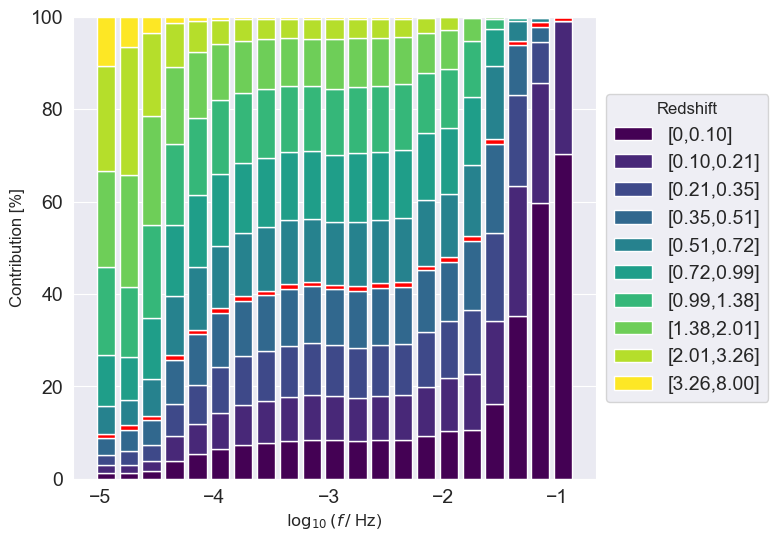

In [26]:
SFH = 1
N_freq = 50
N_int = 20
tag = "example_T"
SAVE = False

data1 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_{tag}.txt.gz", sep = ",")
data2 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_birth_{tag}.txt.gz", sep = ",")
data3 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_merge_{tag}.txt.gz", sep = ",")

stacked_bar_chart(data1, data2, data3, SFH, N_freq, N_int, tag, SAVE)

## Numbers of systems

The number of systems is determined in the main code and stored in the columns "freq_i_num". Such a column stores the number of BWDs in the corresponding frequency bin, for each z bin.

### Summary function

In [27]:
def Summary(SFH: int,N_freq: int, N_int: int, tag: str) -> None:
    '''!
    @brief Print a summary of the number of systems in the different parts of the code.
    @param SFH: The star formation history.
    @param N_freq: The number of frequency bins.
    @param N_int: The number of integration bins.
    @param tag: The tag of the output files.
    '''

    data1b = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_{tag}.txt")
    data2b = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_birth_{tag}.txt")
    data3b = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_merge_{tag}.txt")

    totals1b = []
    totals2b = []
    totals3b = []

    for n in range(N_freq):
        totals1b.append(np.sum(data1b[f"freq_{n}_num"]))
        totals2b.append(np.sum(data2b[f"freq_{n}_num"]))
        totals3b.append(np.sum(data3b[f"freq_{n}_num"]))

    print(f"\n{tag}, {N_freq} bins:\n")

    print(f"Total number of systems in bulk: {np.sum(np.array(totals1b)):.5E}")
    print(f"Total number of systems in birth bins: {np.sum(np.array(totals2b)):.5E}")
    print(f"Total number of systems in merge bins: {np.sum(np.array(totals3b)):.5E}")
    print(f"Total number of systems in non-bulk bins: {np.sum(np.array(totals2b)) + np.sum(np.array(totals3b)):.5E}")

    print(f"\nTOTAL: {np.sum(totals1b) + np.sum(totals2b) + np.sum(totals3b):.5E}")        

In [28]:
Summary(SFH=1, N_freq=50, N_int=20, tag="example_z")


example_z, 50 bins:

Total number of systems in bulk: 6.40352E+16
Total number of systems in birth bins: 1.15576E+17
Total number of systems in merge bins: 2.51468E+16
Total number of systems in non-bulk bins: 1.40723E+17

TOTAL: 2.04758E+17


### Distribution over frequency bins

In [29]:
def distr_over_f(SFH: int, N_freq: int, N_int: int, tag: str, SAVE_FIG: bool = False) -> None:
    '''!
    @brief Create a bar chart of the number of systems in the different frequency bins.
    @param SFH: The star formation history.
    @param N_freq: The number of frequency bins.
    @param N_int: The number of integration bins.
    @param tag: The tag of the output files.
    @param SAVE_FIG: Whether to save the figure or not.
    '''

    data1 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_{tag}.txt")
    data2 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_birth_{tag}.txt")
    data3 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_merge_{tag}.txt")

    totals1 = []
    totals2 = []
    totals3 = []

    for n in range(N_freq):
        totals1.append(np.sum(data1[f"freq_{n}_num"]))
        totals2.append(np.sum(data2[f"freq_{n}_num"]))
        totals3.append(np.sum(data3[f"freq_{n}_num"]))

    f_range = np.logspace(-5, 0, 2*N_freq+1, base = 10)
    f_plot = np.log10(np.array([f_range[2*i+1] for i in range(N_freq)]))

    fig, ax = plt.subplots(1, 3, figsize = (16,6))

    width = (f_plot[2]-f_plot[1])

    ax[0].bar(f_plot, np.array(totals1), color = "red", width=0.8*width, alpha = 0.7)
    ax[0].grid(color = "gainsboro", alpha=  0.7)
    ax[0].set_yscale('log')
    ax[0].set_ylim(10**5, 1e21)
    ax[0].set_title("Bulk")

    ax[1].bar(f_plot, np.array(totals2), color = "red", width=0.8*width, alpha = 0.7)
    ax[1].grid(color = "gainsboro", alpha=  0.7)
    ax[1].set_yscale('log')
    ax[1].set_ylim(10**5, 1e21)
    ax[1].set_title("Birth")

    ax[2].bar(f_plot, np.array(totals3), color = "red", width=0.8*width, alpha = 0.7)
    ax[2].grid(color = "gainsboro", alpha=  0.7)
    ax[2].set_yscale('log')
    ax[2].set_ylim(10**5, 1e21)
    ax[2].set_title("Merge")

    for axis in ax:
        axis.set_xlabel(r"$\log_{10} (f \,/$ Hz)")
    ax[0].set_ylabel("Number of systems")

    if SAVE_FIG:
        fig.savefig("../output/Figures/number_BWDs_comp_50.png", dpi = 1000)

    plt.show()
        

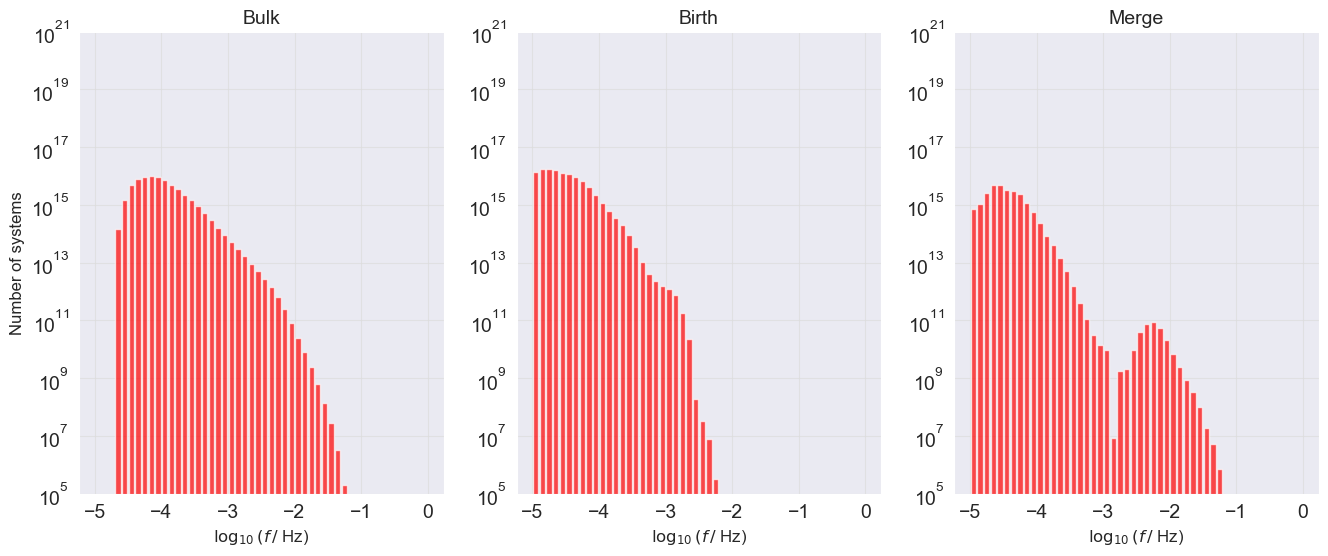

In [30]:
distr_over_f(SFH=1, N_freq=50, N_int=20, tag="example_z")

### Distribution over redshift bins

In [31]:
def distr_over_z(SFH: int, N_freq: int, N_int: int, tag: str, SAVE_FIG: bool = False) -> None:
    '''!
    @brief Create a bar chart of the number of systems in the different redshift bins.
    @param SFH: The star formation history.
    @param N_freq: The number of frequency bins.
    @param N_int: The number of integration bins.
    @param tag: The tag of the output files.
    @param SAVE_FIG: Whether to save the figure or not.
    '''
    
    data1 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_{tag}.txt")
    data2 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_birth_{tag}.txt")
    data3 = pd.read_csv(f"../output/GWBs/SFH{SFH}_{N_freq}_{N_int}_z_contr_merge_{tag}.txt")

    totals1 = []
    totals2 = []
    totals3 = []

    for z in data1["z"]:
        row1 = data1[data1["z"] == z]
        row2 = data2[data2["z"] == z]
        row3 = data3[data3["z"] == z]
        sum1, sum2, sum3 = 0, 0, 0
        for n in range(N_freq):
            sum1 += row1[f"freq_{n}_num"].iloc[0]
            sum2 += row2[f"freq_{n}_num"].iloc[0]
            sum3 += row3[f"freq_{n}_num"].iloc[0]
        totals1.append(sum1)
        totals2.append(sum2)
        totals3.append(sum3)

    fig, ax = plt.subplots(1, 3, figsize = (16,6))

    width = (8 / N_int)

    ax[0].bar(data1["z"], np.array(totals1), color = "red", width=0.8*width, alpha = 0.7)
    ax[0].grid(color = "gainsboro", alpha=  0.7)
    ax[0].set_yscale('log')
    ax[0].set_ylim(10**5, 1e21)
    ax[0].set_title("Bulk")

    ax[1].bar(data2["z"], np.array(totals2), color = "red", width=0.8*width, alpha = 0.7)
    ax[1].grid(color = "gainsboro", alpha=  0.7)
    ax[1].set_yscale('log')
    ax[1].set_ylim(10**5, 1e21)
    ax[1].set_title("Birth")

    ax[2].bar(data3["z"], np.array(totals3), color = "red", width=0.8*width, alpha = 0.7)
    ax[2].grid(color = "gainsboro", alpha=  0.7)
    ax[2].set_yscale('log')
    ax[2].set_ylim(10**5, 1e21)
    ax[2].set_title("Merge")

    for axis in ax:
        axis.set_xlabel(r"$z$")
    ax[0].set_ylabel("Number of systems")

    if SAVE_FIG:
        fig.savefig("../output/Figures/number_BWDs_comp_50.png", dpi = 1000)

    plt.show()


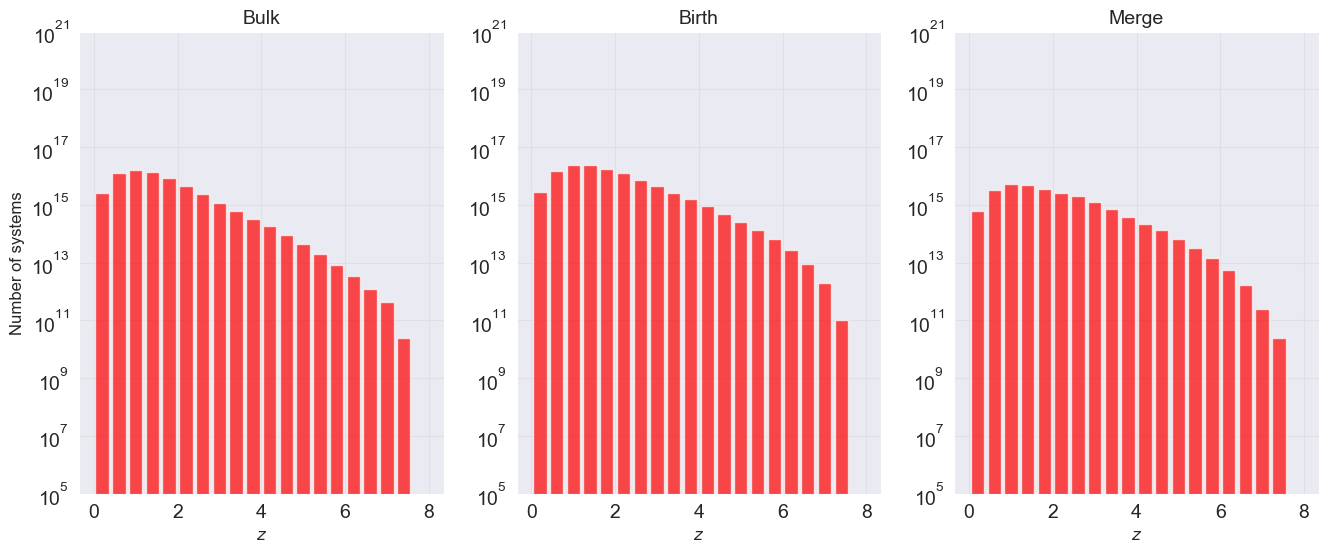

In [32]:
distr_over_z(SFH=1, N_freq=50, N_int=20, tag="example_z")